In [46]:
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
from pprint import pprint
import csv 
import os
from holoviews.util.transform import lon_lat_to_easting_northing
import pycountry



# Import the IPGeolocation API key
from api_key import ip_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy


In [2]:
# Checking validity of the API Key
ip_api_key

'39b2e17c1921415a96991af40d206f5a'

In [3]:
# Read the data and display the sample
card_fraud_path_load = Path("resource/merged_file.csv")
card_data = pd.read_csv(card_fraud_path_load)
card_data.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,0003c9a2-3e18-499f-8b1f-f6f20eecb83c,11.133.155.94,Columbus,39.97883,-82.89573,North America,"Washington, D.C.","Washington, D.C.",2021-03-28 12:02:22,4584.73,...,09/31,162753c27c8b32975a0edf5e89ab4ed8e2f06f02a182e0...,0,1,3 or more,Online,11.133.155.94,Mobile,yuvraj-22,Culpa sit eligendi vel eaque aperiam quo. Sint...
1,001538cf-4b3c-4d81-9cce-fb74fa5c6427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-11 15:30:47,2895.00,...,01/25,1e68ed4e3d58a51096a7feea3947f40debf1fd9246ec97...,12,0,2,Online,102.205.87.49,Desktop,ukhanna,Assumenda amet corporis consectetur asperiores...
2,0016926c-d82a-4070-a0ad-cd1416674744,210.63.242.180,Taipei City,25.05437,121.60681,Asia,Taipei,Taipei,2023-07-16 01:16:14,1492.48,...,12/31,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,5,1,2,In-Person,210.63.242.180,Tablet,NaN,Officiis incidunt minima magnam. Explicabo exp...
3,001b0dd8-5d3b-401a-9093-2093b562e559,175.92.199.54,Beijing,39.90499,116.40529,Asia,Beijing,Beijing,2021-12-08 15:57:04,1077.20,...,03/25,8b6cd7c429e83373dbd412f43d7422c0c4a127d93d0f2a...,12,1,3 or more,In-Person,175.92.199.54,Tablet,NaN,Qui quam ad ipsam ab atque ipsa. Qui tempore q...
4,003014ef-45b3-4743-bc6f-adab9a91a037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-12 03:15:14,2470.89,...,01/30,533eb9a8909f614c351b65e6b8aba1ffc2890735ce9a8a...,12,0,3 or more,Online,205.60.134.240,Desktop,wagletushar,Deserunt fugit impedit odio molestiae reiciend...


In [4]:
# Checking number of rows and columns in the data file
card_data.shape

(8000, 27)

In [5]:
# Checking data types of each column
card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Transaction ID                           8000 non-null   object 
 1   IP                                       3989 non-null   object 
 2   City                                     3980 non-null   object 
 3   Lat                                      3989 non-null   float64
 4   Lng                                      3989 non-null   float64
 5   Continent                                3989 non-null   object 
 6   Capital                                  3989 non-null   object 
 7   Country                                  3989 non-null   object 
 8   Transaction Date and Time                8000 non-null   object 
 9   Transaction Amount                       8000 non-null   float64
 10  Cardholder Name                          8000 no

## This portion of the analysis contain observing Capital and the average fraudulent transaction amounts.

In [51]:
# Count unique number of capital in the database
card_data['Capital'].nunique()

117

In [52]:
# Remove duplicate rows based on Country
card_data_dedup = card_data.drop_duplicates(subset=['Capital'])

# Check that the filtered data frame is the same size as the number of unique countries
card_data_dedup.count()

Transaction ID                             118
IP                                         117
City                                       117
Lat                                        117
Lng                                        117
Continent                                  117
Capital                                    117
Country                                    117
Transaction Date and Time                  118
Transaction Amount                         118
Cardholder Name                            118
Card Number (Hashed or Encrypted)          118
Merchant Name                              118
Merchant Category Code (MCC)               118
Transaction Location (City or ZIP Code)    118
Transaction Currency                       118
Card Type                                  118
Card Expiration Date                       118
CVV Code (Hashed or Encrypted)             118
Transaction Response Code                  118
Fraud Flag or Label                        118
Previous Tran

In [53]:
# Sort the Dataframe by Country
card_data_dedup = card_data_dedup.sort_values('Capital')

# Set country as index
#card_data_dedup.set_index('Country', inplace=True)

In [54]:
# Display Sample Data
card_data_dedup.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
160,05632a69-aa42-4e22-8d1f-8f79f1a403e4,31.215.95.118,Dubai,25.01267,55.09019,Asia,Abu Dhabi,Abu Dhabi,2021-03-01 16:12:18,4947.75,...,10/28,5ef6fdf32513aa7cd11f72beccf132b9224d33f271471f...,12,1,NaN,In-Person,31.215.95.118,Tablet,NaN,Tempora voluptates deserunt vero quo explicabo...
246,07f79037-ef9f-4905-9b20-400b99e1f59c,102.131.133.64,Jos,9.94782,8.88881,Africa,Abuja,Abuja,2020-03-31 13:55:10,777.78,...,07/24,a1e8154bd1a4c96efad1d5bd4a3ecbd73f4f39a44b14b6...,5,1,2,In-Person,102.131.133.64,Desktop,amanikapoor,Recusandae non accusamus doloremque velit. Sit...
1187,242771f0-f84a-4982-bb86-4bf0828a93c4,154.165.89.245,Accra,5.56610,-0.14539,Africa,Accra,Accra,2020-12-02 23:14:23,352.40,...,10/27,5d8f6cce532a7aeb57196be62344095936793400b3aeb3...,5,1,1,In-Person,154.165.89.245,Mobile,NaN,Quia cumque eaque accusantium facere quae fuga...
541,1132d2b7-2c66-4460-ac58-4ec5ff06770a,196.191.204.0,Wereda 02,9.02740,38.75152,Africa,Addis Ababa,Addis Ababa,2020-02-18 21:35:18,2401.90,...,08/30,a73ab888363736220eb589458721088241ee10059b1f58...,5,1,1,Online,196.191.204.0,Desktop,NaN,Sapiente molestiae quasi expedita animi. Illo ...
1443,2d1c800f-dd07-4611-8238-41e252e805cf,197.114.193.93,Algiers,36.77156,3.05930,Africa,Algiers,Algiers,2023-06-13 08:03:25,2332.25,...,07/25,be4b2f45069c180ef309521f6770146920df18e69165c5...,12,1,3 or more,Online,197.114.193.93,Mobile,NaN,Porro perferendis exercitationem facilis volup...


In [55]:
# Find out what are the top countries number of fruads occured 
card_data['Capital'].value_counts()

Capital
Washington, D.C.    1582
Beijing              384
Tokyo                249
Berlin               137
London               136
                    ... 
Sucre                  1
Honiara                1
Managua                1
Dushanbe               1
Doha                   1
Name: count, Length: 117, dtype: int64

In [63]:
# Get mean value of Transaction Amount Per Country
avg_txn_amt_by_cntry = card_data.groupby('Capital', as_index=False)['Transaction Amount'].mean()
avg_txn_amt_by_cntry = avg_txn_amt_by_cntry.sort_values('Capital')
avg_txn_amt_by_cntry['Transaction Amount'] = round(avg_txn_amt_by_cntry['Transaction Amount'],2)

# Display sample data and check that it has the same number of rows as the dedup table
avg_txn_amt_by_cntry

,Capital,Transaction Amount
0,Abu Dhabi,3453.99
1,Abuja,1016.45
2,Accra,1157.85
3,Addis Ababa,2401.90
4,Algiers,2225.78
...,...,...
112,Willemstad,1845.59
113,Windhoek,3163.46
114,Yamoussoukro,4472.12
115,Yerevan,584.52


In [64]:
# Join the dedup dataframe and the fraud transaction mean dataframe
card_data_dedup_txn = pd.merge(card_data_dedup, avg_txn_amt_by_cntry, how="left", on=['Capital'])

# Rename the new merged column to Avg. Transaction Amount
card_data_dedup_txn.rename(columns={'Transaction Amount_y': 'Avg. Transaction Amount'}, inplace=True)

# Reset the index
card_data_dedup_txn.reset_index()

# Display sample data
card_data_dedup_txn.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount_x,...,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes,Avg. Transaction Amount
0,05632a69-aa42-4e22-8d1f-8f79f1a403e4,31.215.95.118,Dubai,25.01267,55.09019,Asia,Abu Dhabi,Abu Dhabi,2021-03-01 16:12:18,4947.75,...,5ef6fdf32513aa7cd11f72beccf132b9224d33f271471f...,12,1,NaN,In-Person,31.215.95.118,Tablet,NaN,Tempora voluptates deserunt vero quo explicabo...,3453.99
1,07f79037-ef9f-4905-9b20-400b99e1f59c,102.131.133.64,Jos,9.94782,8.88881,Africa,Abuja,Abuja,2020-03-31 13:55:10,777.78,...,a1e8154bd1a4c96efad1d5bd4a3ecbd73f4f39a44b14b6...,5,1,2,In-Person,102.131.133.64,Desktop,amanikapoor,Recusandae non accusamus doloremque velit. Sit...,1016.45
2,242771f0-f84a-4982-bb86-4bf0828a93c4,154.165.89.245,Accra,5.56610,-0.14539,Africa,Accra,Accra,2020-12-02 23:14:23,352.40,...,5d8f6cce532a7aeb57196be62344095936793400b3aeb3...,5,1,1,In-Person,154.165.89.245,Mobile,NaN,Quia cumque eaque accusantium facere quae fuga...,1157.85
3,1132d2b7-2c66-4460-ac58-4ec5ff06770a,196.191.204.0,Wereda 02,9.02740,38.75152,Africa,Addis Ababa,Addis Ababa,2020-02-18 21:35:18,2401.90,...,a73ab888363736220eb589458721088241ee10059b1f58...,5,1,1,Online,196.191.204.0,Desktop,NaN,Sapiente molestiae quasi expedita animi. Illo ...,2401.90
4,2d1c800f-dd07-4611-8238-41e252e805cf,197.114.193.93,Algiers,36.77156,3.05930,Africa,Algiers,Algiers,2023-06-13 08:03:25,2332.25,...,be4b2f45069c180ef309521f6770146920df18e69165c5...,12,1,3 or more,Online,197.114.193.93,Mobile,NaN,Porro perferendis exercitationem facilis volup...,2225.78


In [85]:
# Filter columns for Map - Capital, Lat, Lng, Avg transact Amount, Continent, 
map_df = card_data_dedup_txn[['Capital', 'Lat', 'Lng', 'Avg. Transaction Amount', 'Continent']]

# Display sample data
map_df.head()

,Capital,Lat,Lng,Avg. Transaction Amount,Continent
0,Abu Dhabi,25.01267,55.09019,3453.99,Asia
1,Abuja,9.94782,8.88881,1016.45,Africa
2,Accra,5.56610,-0.14539,1157.85,Africa
3,Addis Ababa,9.02740,38.75152,2401.90,Africa
4,Algiers,36.77156,3.05930,2225.78,Africa


In [ ]:
# Convert the coordinates to Web Mercator
map_df['x'], map_df['y'] = lon_lat_to_easting_northing(map_df.Lng, map_df.Lat)
map_df[['Lat', 'Lng', 'x', 'y']].head(3)

In [87]:
# Display sample data
map_df.head()

map_df

,Capital,Lat,Lng,Avg. Transaction Amount,Continent,x,y
0,Abu Dhabi,25.01267,55.09019,3453.99,Asia,6.132612e+06,2.877301e+06
1,Abuja,9.94782,8.88881,1016.45,Africa,9.894978e+05,1.112992e+06
2,Accra,5.56610,-0.14539,1157.85,Africa,-1.618474e+04,6.205923e+05
3,Addis Ababa,9.02740,38.75152,2401.90,Africa,4.313799e+06,1.009109e+06
4,Algiers,36.77156,3.05930,2225.78,Africa,3.405597e+05,4.407313e+06
...,...,...,...,...,...,...,...
113,Windhoek,-22.11350,14.28320,3163.46,Africa,1.589999e+06,-2.525158e+06
114,Yamoussoukro,5.30122,-3.98363,4472.12,Africa,-4.434557e+05,5.909729e+05
115,Yerevan,40.20882,44.53019,584.52,Asia,4.957078e+06,4.896334e+06
116,Zagreb,45.79920,15.98561,2668.00,Europe,1.779510e+06,5.748229e+06


## Analysis
The following image is derived by calling 
 ip Geo location API (web source:  https://app.ipgeolocation.io/) using the IP Address provided in the data source.
 The API uses the IP address passed as an argument and returns information such as the Latitude, Longtitude, Country Name, 
 Country's Capital and Continent which we will use for analysis.

Based on the geo location map below, we observe that most of the credit card fraudulent transactions take place in Europe.

In [107]:
# Plot map - Fraudulent Transactions by Capital
map_plot_1 = map_df.hvplot.points(
    'x', 
    'y', 
    tiles = True,
    frame_width = 800,
    frame_height = 600, 
    alpha=0.7,
    size = 50,
    color = 'Capital',
    hover_cols = ['Capital', 'Avg. Transaction Amount', 'Continent'],
    title='Fraudulent Transactions by Capital'
    )

map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (Capital,Avg. Transaction Amount,Continent)

## Analysis

The average fraudulent transaction amount was calculated and charted against latitue to see if there are any correlations between the two. There does not appear to be any significat correlation between these 2 measures.

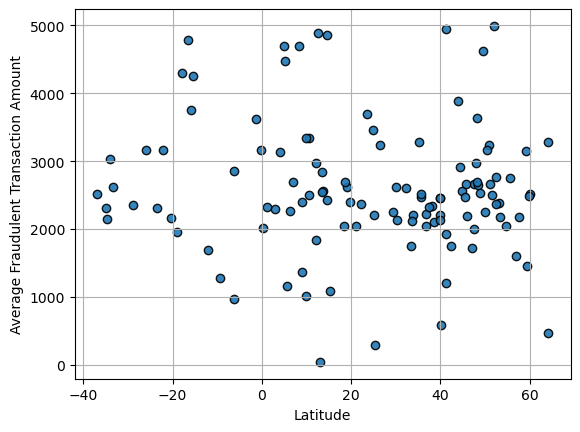

In [77]:
# Build the scatter plots for latitude vs. average fradulent transaction amount
x_values = card_data_dedup_txn['Lat']
y_values = card_data_dedup_txn['Avg. Transaction Amount']

# Plot the scatter plot with datapoints edge folor = black and opicity=90%
plt.scatter(x_values,y_values,alpha=0.9, edgecolors='black')
plt.xlabel('Latitude')
plt.ylabel('Average Fraudulent Transaction Amount')
plt.grid('on')

# Show plot
plt.show()

In [91]:
# Check the count for each continent
map_df['Continent'].value_counts()

Continent
Europe           37
Asia             31
Africa           22
North America    13
South America    10
Oceania           4
Name: count, dtype: int64

## Analysis 

The Pie chart below helps us visualize the distribution of fraudulent activities between continents. As previously note, Europe had the most activities followed by Asia and Africa.

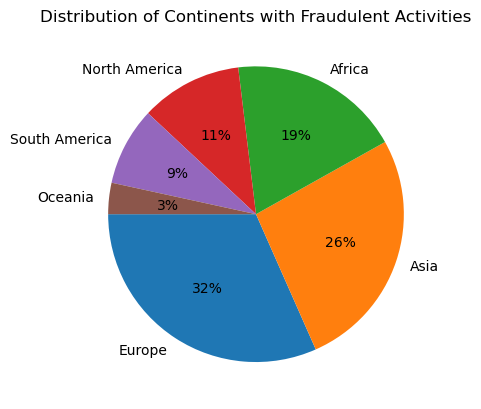

In [106]:
# Generate a pie plot showing the distribution of Continents with fraudulent activities

# Get the labels and values 
seriesLabels_pie = ['Europe','Asia','Africa','North America','South America','Oceania']
seriesValues_pie = map_df['Continent'].value_counts()

# Draw bar chart
plt.pie(seriesValues_pie, labels=seriesLabels_pie, autopct='%1.0f%%',startangle=180)

# Set the labels
plt.title("Distribution of Continents with Fraudulent Activities")

# Show the pie chart
plt.show()